## Manifold Scultping

In this folder, an implementation in Python of the Manifold Scultping algorithm is provided, following the description contained in the paper "Iterative Non-linear Dimensionality Reduction by Manifold Sculpting" by Michael Gashler, Dan Ventura, and Tony Martinez.

In this notebook, the steps are shown one by one in order to illustrate the functioning of the algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D
from manifold_sculpt import *
from utils import *
from dim_reduction_algorithms import *
import os

import ipywidgets as widgets

### 1st step: find k nearest neighbors of each point
### 2nd point: compute relationships between neighbors


These two steps are merged in a unique one which is implemented by the function `get_local_relationships(data, k)`, which takes as input the data matrix `X` and the number of neighbors `k` and returns the matrices of relationships between neighbors and the average distance between each point and its neighbors.

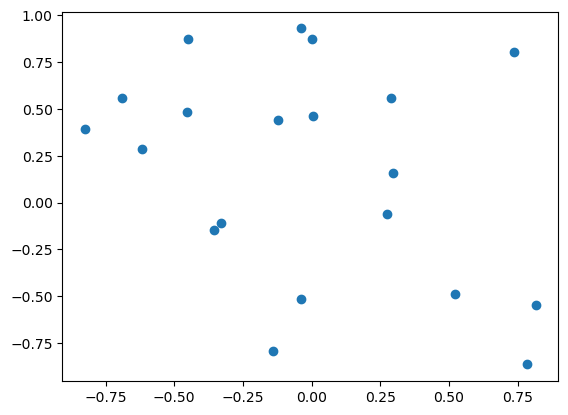

In [2]:
# generate random datapoints
# generate random points in 2d and plot them
data = np.random.uniform(-1, 1, (20, 2))
plt.scatter(data[:,0], data[:,1])
plt.show()

In [3]:
# call function to get the desired relationships
neighbors, dist, colinear, theta, avg_dist = get_local_relationships(data, k=5)

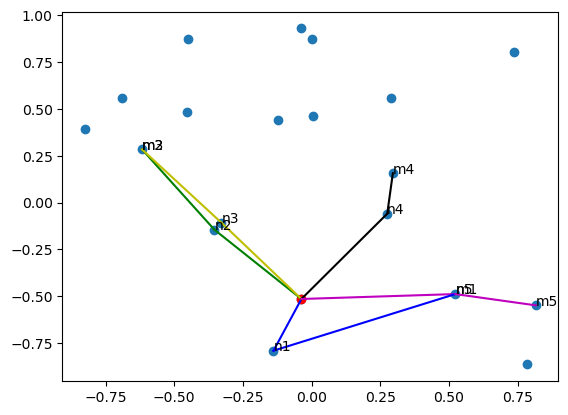

In [4]:
# choose one point and plot relationships
point = 15
plt.scatter(data[:,0], data[:,1])
plt.scatter(data[point,0], data[point,1], c='r')

color = ['b', 'g', 'y', 'k', 'm']
for i in range(5):
    j = int(neighbors[point, i])
    plt.plot([data[point,0], data[j,0]], [data[point,1], data[j,1]], c=color[i])
    plt.annotate('n%d' %(i+1), (data[j,0], data[j,1]))


# plot the most colinear neighbor of each neighbor of the chosen point
for i,idx in enumerate(colinear[point,:]):
    j = int(neighbors[point, i])
    plt.plot([data[j,0], data[int(idx),0]], [data[j,1], data[int(idx), 1]], c=color[i])
    plt.annotate('m%d' %(i+1), (data[int(idx),0], data[int(idx),1]))

plt.show()


### Step 3: optionally preprocess the data

The following steps are illustrated on the data set `swiss_roll` which is a 3D data set with a non-linear structure. The data set is loaded and plotted below.

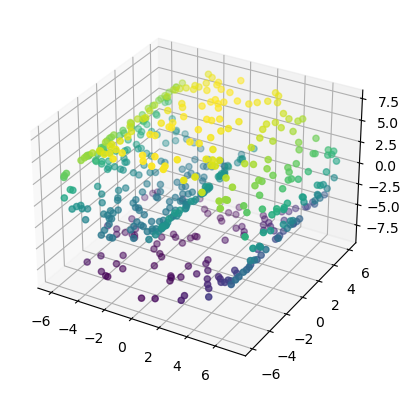

In [5]:
# load swiss roll dataset from csv file
if os.path.exists('swiss_roll.csv'):
    data = np.genfromtxt('swiss_roll.csv', delimiter=',')
else:
    # generate swiss roll dataset
    data = generate_swiss_roll(500)

# center the data
X = data - np.mean(data, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,2], cmap='viridis')

plt.show()

PCA is used to (optionally) to rotate the axes to align with the principal components. No projection is performed, then the implementation provided for PCA removes the last step of the standard PCA algorithm.

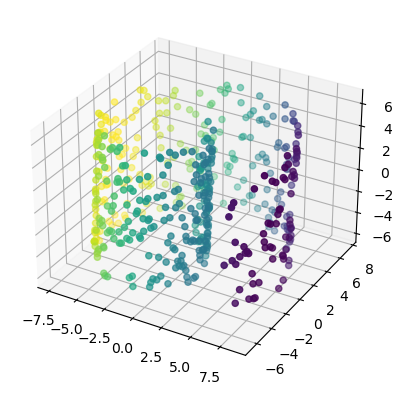

In [6]:
#%matplotlib widget  

# apply pca to the data
idx, U = pca_alg(X, 3) # keep all dimensions to see just the rotation
y = np.dot(X, U)

# plot the data in the new space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0], y[:,1], y[:,2], c=X[:,2], cmap='viridis')

plt.show()

In [7]:
idx

array([0, 1, 2], dtype=int64)

This is the result of the PCA preprocessing step, if we apply also the projection, we the result in the plot below.

Manifold Sculpting uses PCA only to to align axes with principal components in order to make the algorithm faster, but the projection is not performed, it is progressively achieved thorugh an iterative procedure.

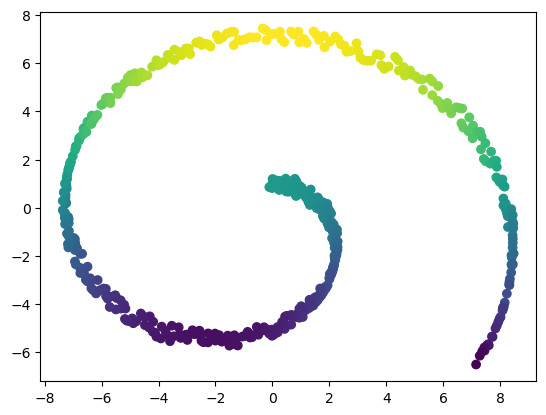

In [8]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(y[:,0], y[:,1], c=X[:,0], cmap='viridis')

Going back for a moment to what concerns step 1 and 2.

An important thing to decide, related to dataset we are dealing with, is hyperparameter $k$, which is the number of neighbors to be considered.
This is very important, a suitable value can be found by visualizing which points are connected and avoid to have too many points connected across different parts of the manifold.

In [9]:
ds = copy.deepcopy(X)
nn=12

# call function to get the desired relationships
neighbors, dist, colinear, theta, avg_dist = get_local_relationships(ds, k=nn)
neighbors.shape

(500, 12)

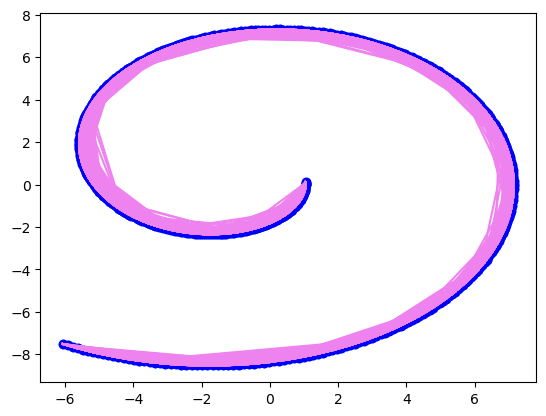

In [10]:
%matplotlib inline

# choose one point and plot relationships
plt.scatter(ds[:,0], ds[:,2])
for point in range(data.shape[0]):
    plt.scatter(ds[point,0], ds[point,2], c='b')

# plot the neighbors of each point
for point in range(data.shape[0]):
    for i in range(nn):
        j = int(neighbors[point, i])
        plt.plot([ds[point,0], ds[j,0]], [ds[point,2], ds[j,2]], c='violet')


# plot the most colinear neighbor of each neighbor for each point
for point in range(data.shape[0]):
    for i,idx in enumerate(colinear[point,:]):
        plt.plot([ds[point,0], ds[int(idx),0]], [ds[point,2], ds[int(idx), 2]], c='violet')


plt.show()

### Step 4: Transform the data
- Scale the values along the dimensions to be discarded.
- Restore the original relationships found at step 2.

### Step 5: project the data

This steps are implemented by the function which fits the data, inside the ManifoldScultping class.

In [11]:
ms = ManifoldSculpting(n_components=2, k=12, n_iter=100, sigma = 0.95, th = 10**(-5), align=True, verbose=True, starting_point=300)
ms.fit(X)

Dimensions which are going to be preserved:  [0 1]
Dimensions which are going to be discarded:  [2]
Iteration: 0, change: 269.8916454016045
Iteration: 10, change: 710.6329864304209
Iteration: 20, change: 373.21314832858013
Iteration: 30, change: 45.2415831513902
Iteration: 40, change: 33.35156410696702
Iteration: 50, change: 139.40590477522522
Iteration: 60, change: 11.662462323514303
Iteration: 70, change: 2.0483869931184584
Iteration: 80, change: 1.2264449586357717
Iteration: 90, change: 0.7343179006782419
Final reconstruction error: 290.95971880483995


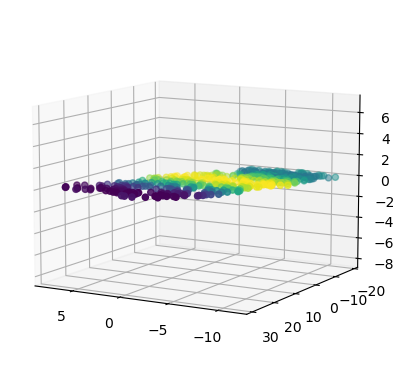

In [12]:
%matplotlib inline  

# get embedding
y = ms.transformed_data
y.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0], y[:,1], y[:,2], c=X[:,2], cmap='viridis')


# change the angle of the axes
ax.view_init(10, 120)

if ms.dscal == 0:
    ax.set_xlim(np.min(X[:,0]),np.max(X[:,0]))
elif ms.dscal == 1:
    ax.set_ylim(np.min(X[:,1]),np.max(X[:,1]))
else:
    ax.set_zlim(np.min(X[:,2]),np.max(X[:,2]))

plt.show()

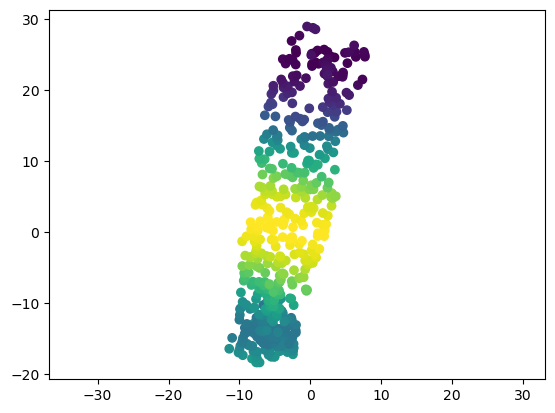

In [13]:
%matplotlib inline

ms_embed = ms.embedding
plt.scatter(ms_embed[:,0], ms_embed[:,1], c=X[:,2], cmap='viridis')
# make axis equal
plt.axis('equal')
plt.show()

### Comparisons

Let's check which is the behavior of other **manifold learning** techniques we have seen, on the same dataset.

1. **Isomap**
2. **t-SNE**
3. **LLE**
4. **Umap**
5. **Diffusion Map**

In [16]:
from sklearn import manifold
from dim_reduction_algorithms import isomap_alg, knn_graph #diffusion_map
import umap

# compute embeddings for comparison

# isomap
#isomap = manifold.Isomap(n_components=2, n_neighbors=12, path_method='FW', neighbors_algorithm='brute')
#isomap.fit(X)
isomap_embed, _, _ = isomap_alg(ds, n_neighbors=12) # use my implementation of isomap

# tsne
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate='auto')
tsne_embed = tsne.fit_transform(X)

# LLE
lle_embed, _ = manifold.locally_linear_embedding(ds, n_neighbors=12, n_components=2)

# umap
umap_class = umap.UMAP(n_components=2, n_neighbors=12,  min_dist=0.5, metric='euclidean')
uembed = umap_class.fit_transform(X)

# diffusion map
diff_embed = diffusion_map(ds, n_components=2, time=10, mode='distance')


c:\Users\Erika\AppData\Local\R-MINI~1\envs\deep-learn\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


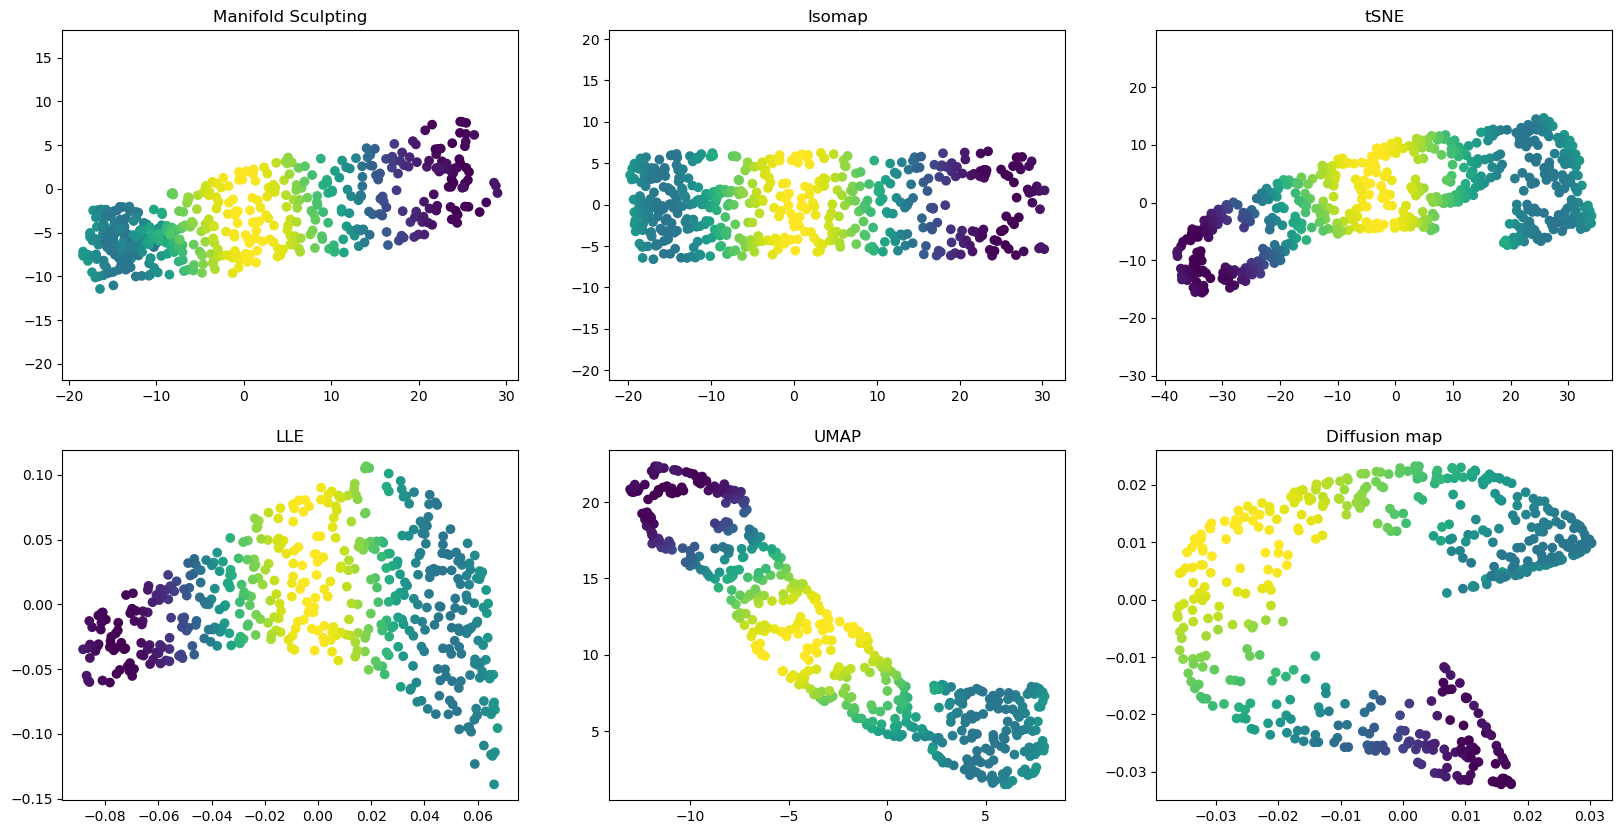

In [17]:
%matplotlib inline
# make one plot with all the methods to be compared

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(231)
ax.scatter(ms_embed[:,1], ms_embed[:,0], c=X[:,2], cmap='viridis')
ax.set_title('Manifold Sculpting')
plt.axis('equal')

# isomap

ax = fig.add_subplot(232)
ax.scatter(isomap_embed[0,:], isomap_embed[1,:], c=X[:,2], cmap='viridis')
ax.set_title('Isomap')
plt.axis('equal')

# tSNE

ax = fig.add_subplot(233)
ax.scatter(tsne_embed[:,0], tsne_embed[:,1], c=X[:,2], cmap='viridis')
ax.set_title('tSNE')
plt.axis('equal')

# LLE 

ax = fig.add_subplot(234)
ax.scatter(lle_embed[:, 0], lle_embed[:, 1], c=X[:,2], cmap='viridis')
ax.set_title('LLE')

# umap

ax = fig.add_subplot(235)
ax.scatter(uembed[:,0], uembed[:,1], c=X[:,2], cmap='viridis')
ax.set_title('UMAP')

# diffusion map

ax = fig.add_subplot(236)
ax.scatter(diff_embed[:,0], diff_embed[:,1], c=X[:,2], cmap='viridis')
ax.set_title('Diffusion map')

plt.show()

### Poorly sampled areas

The most competitive one seems to be Isomap, let's check how they behave with respect to poorly sampled regions in our dataset. 

Let's check the follwoing example.

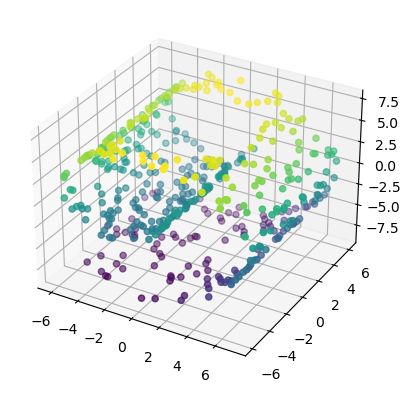

In [18]:
# remove some points from our dataset in order
# for some regions to be poorly sampled
tbr = [X[i,2] < 6 or ((X[i,0] > 3 or X[i,0] < -3) or (X[i,1] > 3 or X[i,1] < -3)) for i in range(X.shape[0])]
ps_X = X[tbr]

# center the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ps_X[:,0], ps_X[:,1], ps_X[:,2], c=ps_X[:,2], cmap='viridis')

In [39]:
ps_X.shape

(471, 3)

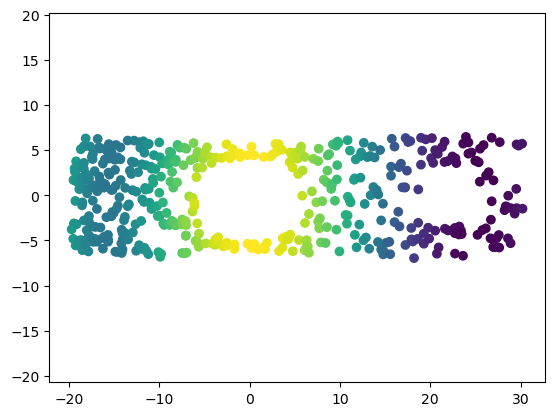

In [40]:
ip,_,_ = isomap_alg(ps_X, n_neighbors=12)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ip[0,:], ip[1,:], c=ps_X[:,2], cmap='viridis')
plt.axis('equal')

plt.show()

In [46]:
ms2 = ManifoldSculpting(n_components=2, k=12, n_iter=100, sigma = 0.95, th = 10**(-5), align=False, verbose=True, starting_point=250)
ms2.fit(ps_X)

Dimensions which are going to be preserved:  [2 0]
Dimensions which are going to be discarded:  [1]
Iteration: 0, change: 254.77733585666437
Iteration: 10, change: 810.5627493698271
Iteration: 20, change: 447.43404023753067
Iteration: 30, change: 51.77331310425727
Iteration: 40, change: 52.90272526512188
Iteration: 50, change: 12.443172762034909
Iteration: 60, change: 8.377303662294146
Iteration: 70, change: 5.665072699589954
Iteration: 80, change: 8.080451842179869
Iteration: 90, change: 5.765181491988893
Final reconstruction error: 87.33669809373731


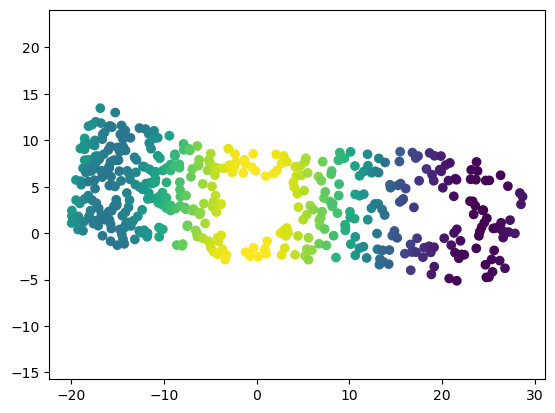

In [48]:
%matplotlib inline

y = ms2.embedding
plt.scatter(y[:,1], y[:,0], c=ps_X[:,2], cmap='viridis')
# make axis equal
plt.axis('equal')
plt.show()

In [57]:
ms2 = ManifoldSculpting(n_components=2, k=12, n_iter=100, sigma = 0.95, th = 10**(-5), align=True, verbose=True, starting_point=0)
ms2.fit(ps_X)

Dimensions which are going to be preserved:  [1 0]
Dimensions which are going to be discarded:  [2]
Iteration: 0, change: 254.99369321081934
Iteration: 10, change: 901.8610538927718
Iteration: 20, change: 649.4352734340854
Iteration: 30, change: 464.57131434842756
Iteration: 40, change: 419.79200902348055
Iteration: 50, change: 219.53525335889918
Iteration: 60, change: 455.1803950770232
Iteration: 70, change: 176.94585024882616
Iteration: 80, change: 45.27399439644871
Iteration: 90, change: 4.845375775872166
Final reconstruction error: 93.90574804412525


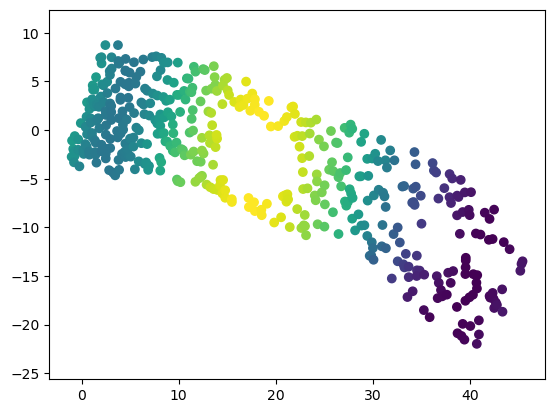

In [58]:
%matplotlib inline

y = ms2.embedding
plt.scatter(y[:,1], y[:,0], c=ps_X[:,2], cmap='viridis')
# make axis equal
plt.axis('equal')
plt.show()